In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [3]:
processed_dataset  = "processed_data"

# Neural networks micro framework

In [4]:
import jax
import jax.numpy as jnp
from jax import lax
from jax.lax import dynamic_slice

In [5]:
def conv3D(grid,W):
    G = grid.copy()
    def relu(x):
        return jnp.maximum(0,x)
    
    # put zeros "around"
    G = jnp.pad(G,int(W.shape[0]/2))
    
    G = jax.vmap(
            lambda i:
            jax.vmap(
                lambda j:
                jax.vmap(
                    lambda k:
                        ( 
                                (dynamic_slice( G,(i - int(W.shape[0] / 2.) , j - int(W.shape[1] / 2.), k - int(W.shape[2] / 2.)) , 
                                      (W.shape[0],W.shape[1],W.shape[2]) ) * W).sum()
                        )
                )( jnp.arange( int(W.shape[2] / 2.) ,G.shape[2] - int(W.shape[2] / 2.)).astype(int) )
            )( jnp.arange( int(W.shape[1] / 2.), G.shape[1] - int(W.shape[1] / 2.)).astype(int) )
        )( jnp.arange( int(W.shape[0] / 2.), G.shape[0] - int(W.shape[0] / 2.)).astype(int) )
        
    return G
conv3D = jax.jit(conv3D)

In [6]:
def relu(x,w = 1.,b = 0.):
    return jnp.maximum(0,x * w + b)

def sigmoid(x,w = 1.,b = 0.):
    return (jnp.tanh(x * w + b) + 1.)/2.

def tanh(x,w=1.,b=0.):
    return jnp.tanh(x * w + b)

In [7]:
def linear(layer,W,b):
    return W @ layer + b

def add(layer,b):
    return layer + b

# Loading csvs

In [11]:
import os
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations   = []
centers_of_mass = []
finger_prints   = []


for i in range(N):
    voxelization   = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"     % (processed_dataset,i)))
    center_of_mass = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy" % (processed_dataset,i)))
    finger_print   = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"     % (processed_dataset,i)))
    
    voxelizations.append(voxelization)
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
10 su 101
20 su 101
30 su 101
40 su 101
50 su 101
60 su 101
70 su 101
80 su 101
90 su 101
100 su 101


In [14]:
shapes      = np.array([ np.array(a.shape) for a in voxelizations ])
magic_shape = shapes.max(axis = 0)
magic_shape

array([74, 66, 81])

# Padding

In [15]:
def padding(array, requested_shape):
    xx = requested_shape[0]
    yy = requested_shape[1]
    zz = requested_shape[2]
    
    sa = array.shape[0]
    sb = array.shape[1]
    sc = array.shape[2] 
    
    a = (xx - sa) // 2
    aa = xx - a - sa
    b = (yy - sb) // 2
    bb = yy - b - sb
    c = (zz - sc) // 2
    cc = zz - c - sc
    
    return jnp.pad(array, pad_width=((a, aa), (b, bb), (c,cc)), mode='constant')

In [16]:
def extract_batch(magic_shape,source, idx_list):
    return jnp.array([
            padding(source[idx] , magic_shape)
        for idx in idx_list
    ])

# Center of mass gaussianization

In [ ]:
def center_of_mass_gaussianization(
        com,
        voxelization,
        sigma_sq
):
    # ritorna una voxelgrid in cui il centro di massa é rappresentato attraverso una gaussiana 
    # di varianza sigma_sq

# Network

###  Rete

In [18]:
def logistic_model(kernels_tensor_flux, 
                   biases_tensor_flux,                   
                   grid):
        
    x            = conv3D(grid, 
                          kernels_tensor_flux[0])
    x            = relu(x ,
                        b = biases_tensor_flux[0])
    
    for W,b in zip(kernels_tensor_flux[1:][:-1], biases_tensor_flux[1:][:-1]):
        x        = conv3D(x,  W)
        x        = relu(x,b = b)
    
    x            = conv3D(x, kernels_tensor_flux[-1])
    x            =    add(x, biases_tensor_flux[-1] )
    
    return x
    

def generate_params_big_model( flux_topology ):
    
    kernels_tensor_flux = []
    biases_tensor_flux  = []
    
    for k in flux_topology:
        kernels_tensor_flux.append( 
            jnp.array(
                np.random.normal(
                    size = (k,k,k)
                ) 
                * 
                np.sqrt(
                    2./ (k * k * k)
                )
            ) 
        )
        biases_tensor_flux.append(0.)

    
    return kernels_tensor_flux, biases_tensor_flux

### Loss function

In [19]:
def loss(    
       kernels_tensor_flux, 
       biases_tensor_flux,
       grid,
       A):
    
    A_hat = logistic_model(
                   kernels_tensor_flux, 
                   biases_tensor_flux,
                   grid)
    
    
    return ((A - A_hat)**2).mean()


loss = jax.jit(loss)
grad = jax.grad(loss,argnums = (0,1))
grad = jax.jit(grad)

In [22]:
def batch_loss(    
                   kernels_tensor_flux, 
                   biases_tensor_flux,
    
                   grids,
                   As):
    
    
        return jax.vmap(
          lambda 
              grid, A:
              (
                  (
                    logistic_model( 
                                    kernels_tensor_flux, 
                                    biases_tensor_flux,
                                    grid
                                   ) 
                     - A)**2 * (A > 0.0)
                   ).mean() / (A > 0.0).mean()
              )(
                  grids,
                  As
              ).mean()
    
batch_loss = jax.jit(batch_loss)
batch_grad = jax.grad(batch_loss,argnums = (0,1))
batch_grad = jax.jit(batch_grad)

# Training

## Random generated parameters

In [25]:
np.random.seed(123)
ktf, btf = generate_params_big_model( [5 for k in range(12)])

## Training Loop

0
	0.05790
	0.07130
	0.06332
	0.06244
	0.05117
	0.05052
	0.04912
	0.04961
	0.05065
	0.05037
	0.05028
	0.05143
	0.05005
	0.05019
	0.05029
	0.04953
	0.04785
	0.04934
	0.04908
	0.05048
	0.04994
	0.05018
	0.04829
	0.04888
	0.04865
	0.04735
	0.04820
	0.04979
	0.04990
	0.04887
	0.04929
	0.05046
	0.04758
	0.04875
	0.04968
	0.05017
	0.04874
	0.04848
	0.04818
	0.04841
	0.04974
	0.04942
	0.04904
	0.04892
	0.04970
	0.04985
	0.04735
	0.05038
	0.04909
	0.05183
0.05060097


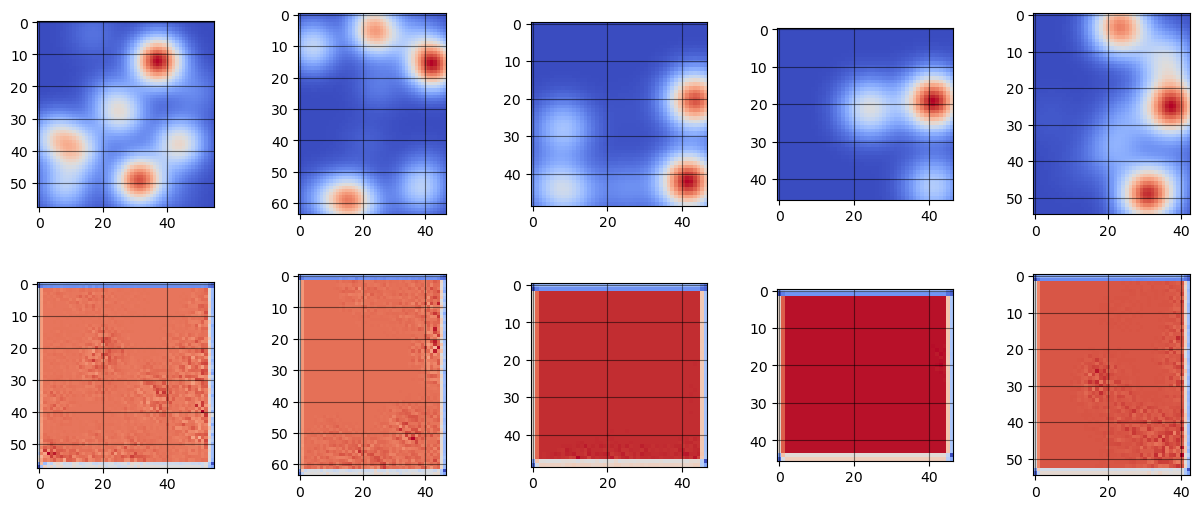

1
	0.04831
	0.04994
	0.04850
	0.04840
	0.04775
	0.04972
	0.04812
	0.05035
	0.04991
	0.04815
	0.04920
	0.04982
	0.04917
	0.04903
	0.04832
	0.04975
	0.05067
	0.04944
	0.04972
	0.04854
	0.04862
	0.04900
	0.05074
	0.04939
	0.04987
	0.05139
	0.04967
	0.04973
	0.04885
	0.04896
	0.05101
	0.04946
	0.04986
	0.04890
	0.04877
	0.04865
	0.05000
	0.05007
	0.04980
	0.04897
	0.04903
	0.05085
	0.04937
	0.04981
	0.05085
	0.04939
	0.04882
	0.04928
	0.04794
	0.05084
0.049413458


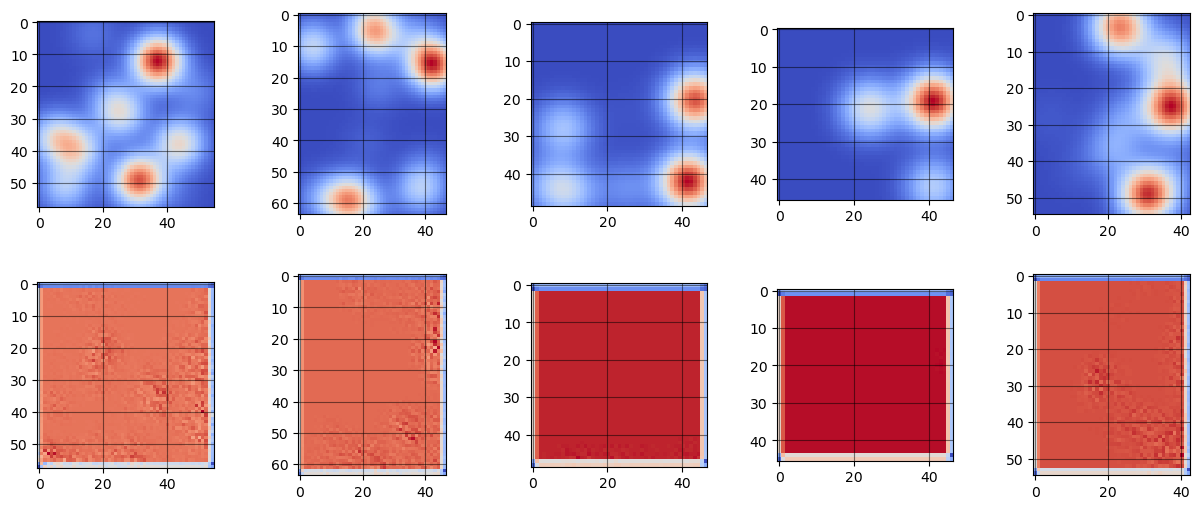

2
	0.04914
	0.05076
	0.04850
	0.04998
	0.04903
	0.04980
	0.04992
	0.04867
	0.04983
	0.05021
	0.04821
	0.04894
	0.04987
	0.04973
	0.04985
	0.04937
	0.04802
	0.04923
	0.04926
	0.04932
	0.04766
	0.04990
	0.04816
	0.04957
	0.04882
	0.04838
	0.04964
	0.04922
	0.04871
	0.04828
	0.04912
	0.05045
	0.04985
	0.05131
	0.04725
	0.05050
	0.04908
	0.04870
	0.04933
	0.04966
	0.05004
	0.04945
	0.05012
	0.04950
	0.04977
	0.04958
	0.04984
	0.05131
	0.04999
	0.04812
0.049378958


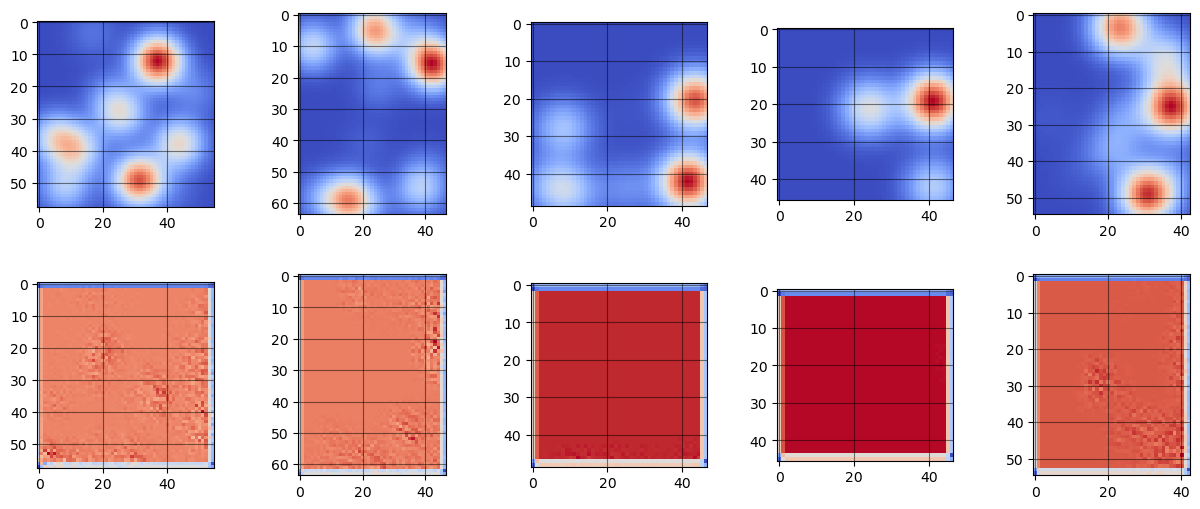

3
	0.05007
	0.04959
	0.04874
	0.04832
	0.04946
	0.04935
	0.04672
	0.04895
	0.05021
	0.04752
	0.05092
	0.05030
	0.05031
	0.05016
	0.04769
	0.05216
	0.04824
	0.04919
	0.04818
	0.05029
	0.04814
	0.05038
	0.05043
	0.04517
	0.04841
	0.04997
	0.04937
	0.04916
	0.04694
	0.04924
	0.04960
	0.04989
	0.05081
	0.04996
	0.04934
	0.05131
	0.04878
	0.05126
	0.04768
	0.04882
	0.05030
	0.05001
	0.04728
	0.04882
	0.04914
	0.05114
	0.04946
	0.05078
	0.04974
	0.04927
0.049339447


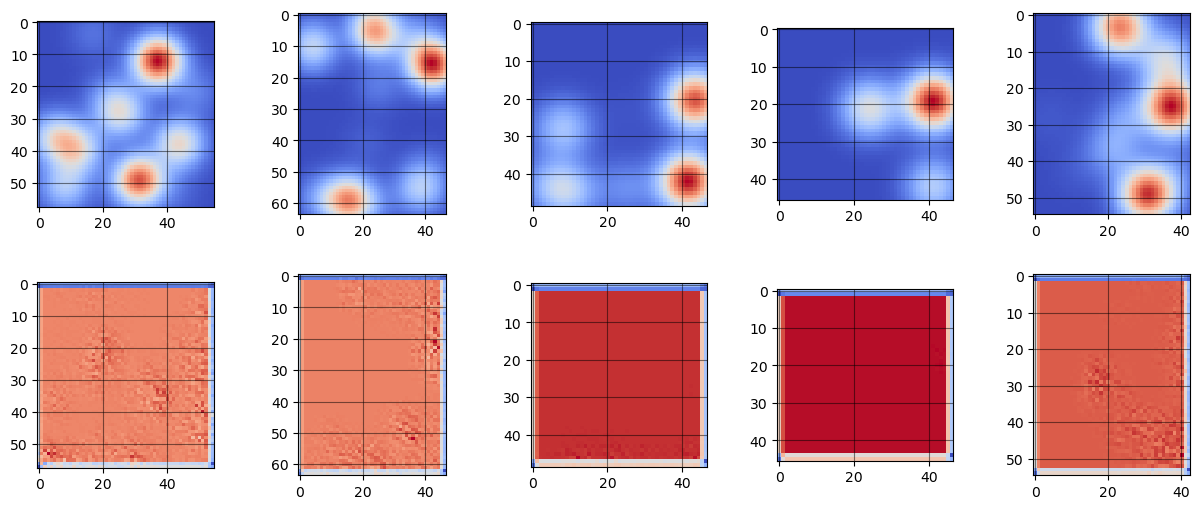

4
	0.05001
	0.04778
	0.04947
	0.04930
	0.04754
	0.04884
	0.04939
	0.05093
	0.04772
	0.04998
	0.04869
	0.05185
	0.04893
	0.04806
	0.04952
	0.04953
	0.04943
	0.04979
	0.04801
	0.04869
	0.04969
	0.04863
	0.04894
	0.04811
	0.05051
	0.04953
	0.04781
	0.04900
	0.04940
	0.04949
	0.04934
	0.04940
	0.05026
	0.04991
	0.04658
	0.04878
	0.05000
	0.04927
	0.05034
	0.04798
	0.05093
	0.05021
	0.04821
	0.04968
	0.04749
	0.05112
	0.05116
	0.04929
	0.04971
	0.05084
0.049301043


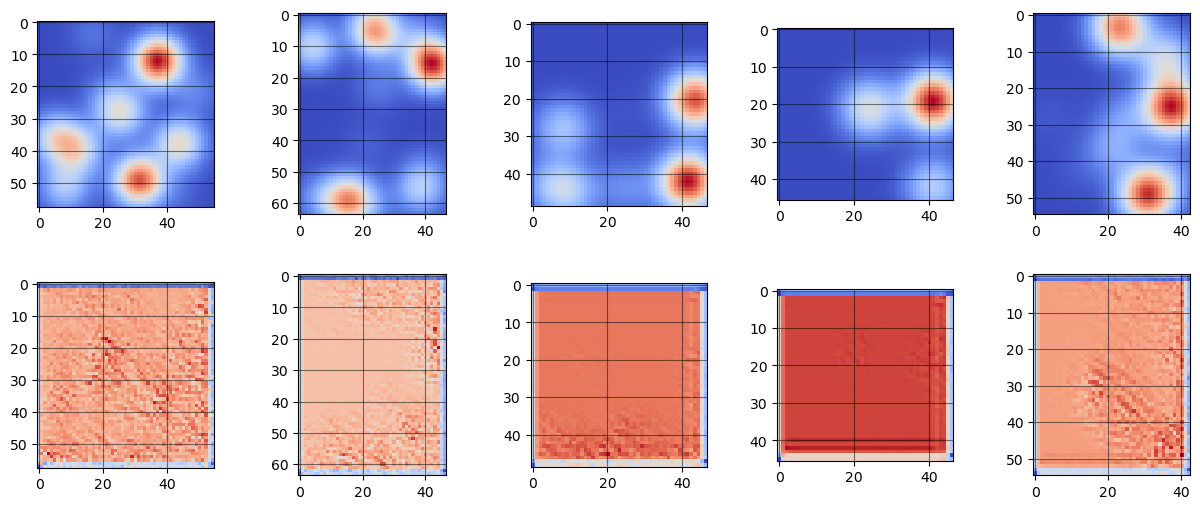

5
	0.05045
	0.04957
	0.04961
	0.05014
	0.04886
	0.04993
	0.04983
	0.05039
	0.04916
	0.04967
	0.04742
	0.04963
	0.04894
	0.04778
	0.04986
	0.04869
	0.04926
	0.04723
	0.05080
	0.04780
	0.04867
	0.04799
	0.04969
	0.04764
	0.04796
	0.04829
	0.04738
	0.04623
	0.04819
	0.04844
	0.04799
	0.04642
	0.04747
	0.04726
	0.04659
	0.04846
	0.04687
	0.04552
	0.04691
	0.04696
	0.04844
	0.05033
	0.04812
	0.04622
	0.04778
	0.04868
	0.04675
	0.04375
	0.04591
	0.04884
0.04821547


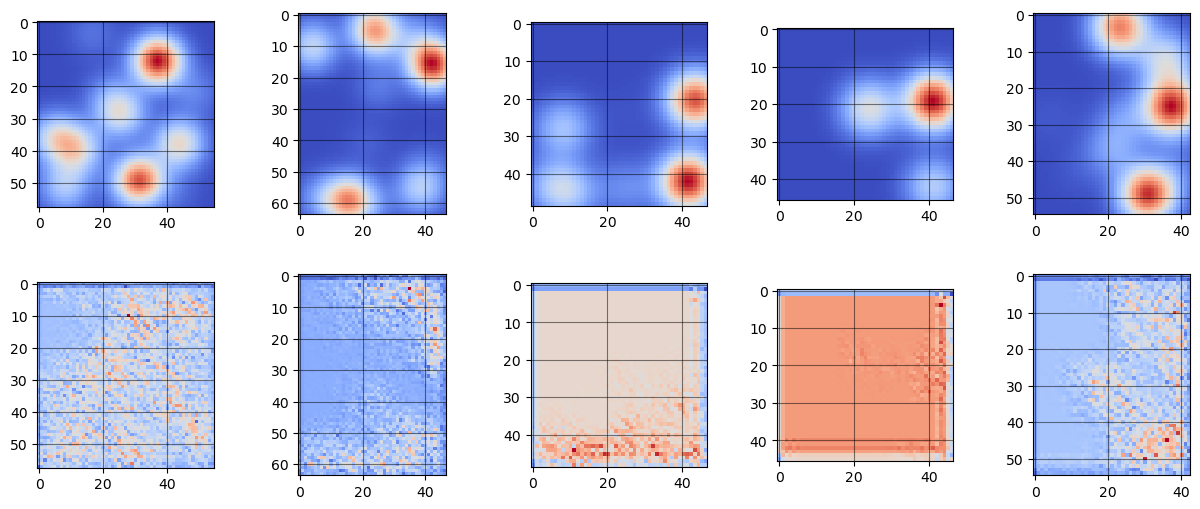

6
	0.04456
	0.04422
	0.04310
	0.04577
	0.04792
	0.05925
	0.04688
	0.04754
	0.04435
	0.04380
	0.04209
	0.04212
	0.04072
	0.04610
	0.06937
	0.05403
	0.04571
	0.04637
	0.04168
	0.03783
	0.04400
	0.05103
	0.03924
	0.04228
	0.04273
	0.05145
	0.03998
	0.03907
	0.03917
	0.04616
	0.03830
	0.03643
	0.04087
	0.05031
	0.03623
	0.03729
	0.03692
	0.04483
	0.06716
	0.05520
	0.05579
	0.05350
	0.05109
	0.04887
	0.04795
	0.04603
	0.04508
	0.04094
	0.04244
	0.04091
0.045693196


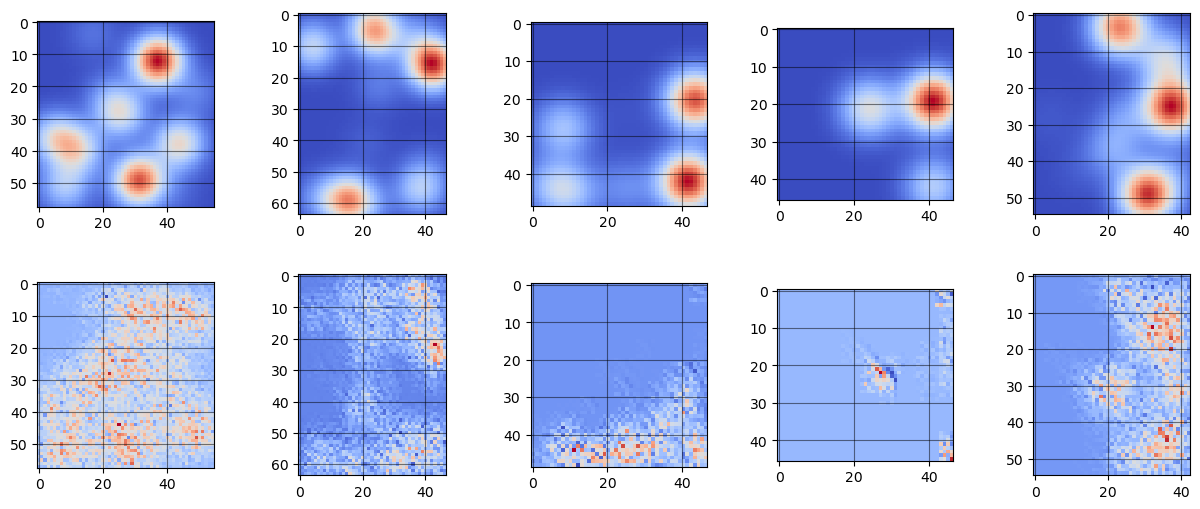

7
	0.04037
	0.03858
	0.03838
	0.03835
	0.03829
	0.04101
	0.03651
	0.03834
	0.03755
	0.03461
	0.03712
	0.03628
	0.03508
	0.03462
	0.03493
	0.03590
	0.03986
	0.06071
	0.05546
	0.04862
	0.04606
	0.03908
	0.03721
	0.03607
	0.03698
	0.03716
	0.03809
	0.03764
	0.03706
	0.03750
	0.03836
	0.06019
	0.05323
	0.04995
	0.04481
	0.03963
	0.03796
	0.03661
	0.03834
	0.03641
	0.03937
	0.03629
	0.03573
	0.03506
	0.03595
	0.03488
	0.03419
	0.03386
	0.03501
	0.05105
0.03980653


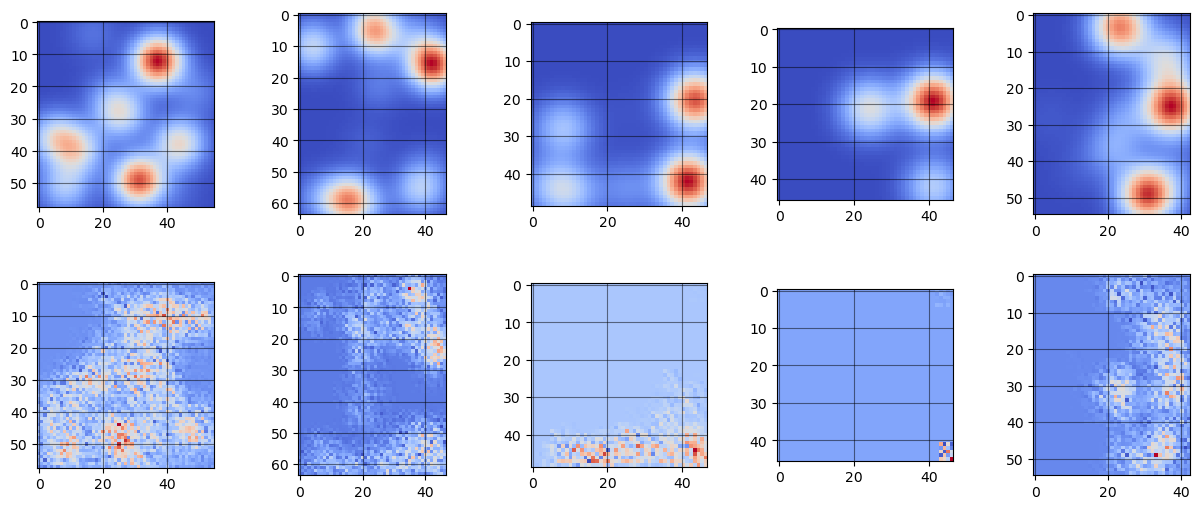

8
	0.03545
	0.03528
	0.04509
	0.03651
	0.03374
	0.03514
	0.03686
	0.03953
	0.03919
	0.04451
	0.03231
	0.03823
	0.03833
	0.03756
	0.03935
	0.05989
	0.04934
	0.03766
	0.03634
	0.03670
	0.03433
	0.04148
	0.03429
	0.03450
	0.03653
	0.03628
	0.04805
	0.03586
	0.03352
	0.03451
	0.03787
	0.03961
	0.04115
	0.03455
	0.04853
	0.03499
	0.03471
	0.03282
	0.03416
	0.03259
	0.03289
	0.03395
	0.03516
	0.04599
	0.03300
	0.04714
	0.03277
	0.03232
	0.03273
	0.03485
0.03776223


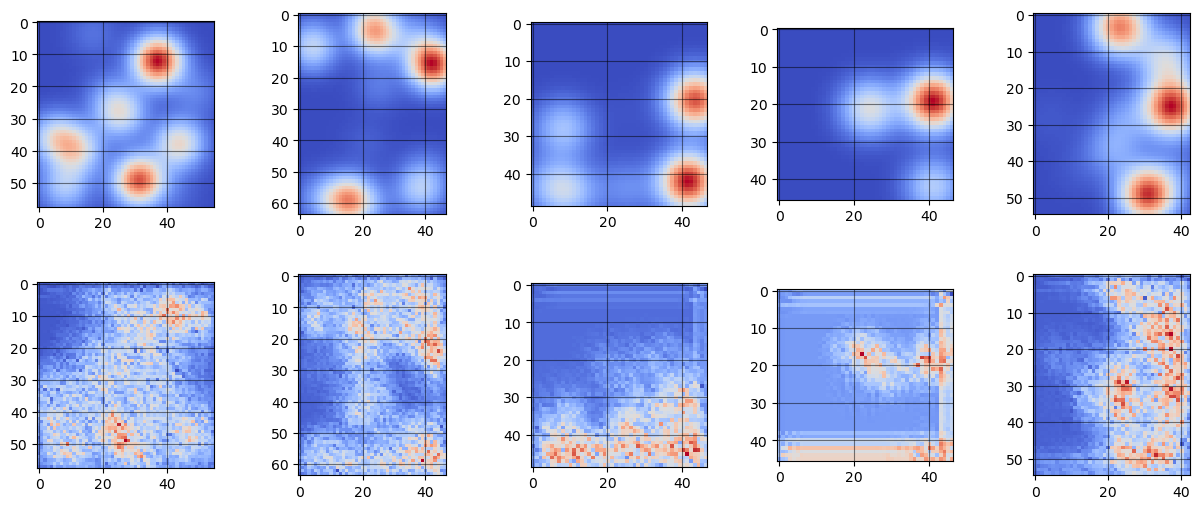

9
	0.03391
	0.03370
	0.03445
	0.03276
	0.03652
	0.04407
	0.06074
	0.05836
	0.05155
	0.04142
	0.03473
	0.03271
	0.03453
	0.04485
	0.03249
	0.03398
	0.03194
	0.03166
	0.03298
	0.03352
	0.04248
	0.03383
	0.03095
	0.03166
	0.03331
	0.05038
	0.03971
	0.03754
	0.04161
	0.03592
	0.03545
	0.03293
	0.03913
	0.04029
	0.05785
	0.03856
	0.03272
	0.03095
	0.03403
	0.03275
	0.03833
	0.04170
	0.03250
	0.03131
	0.03112
	0.03404
	0.03447
	0.03762
	0.03622
	0.05174
0.0378398


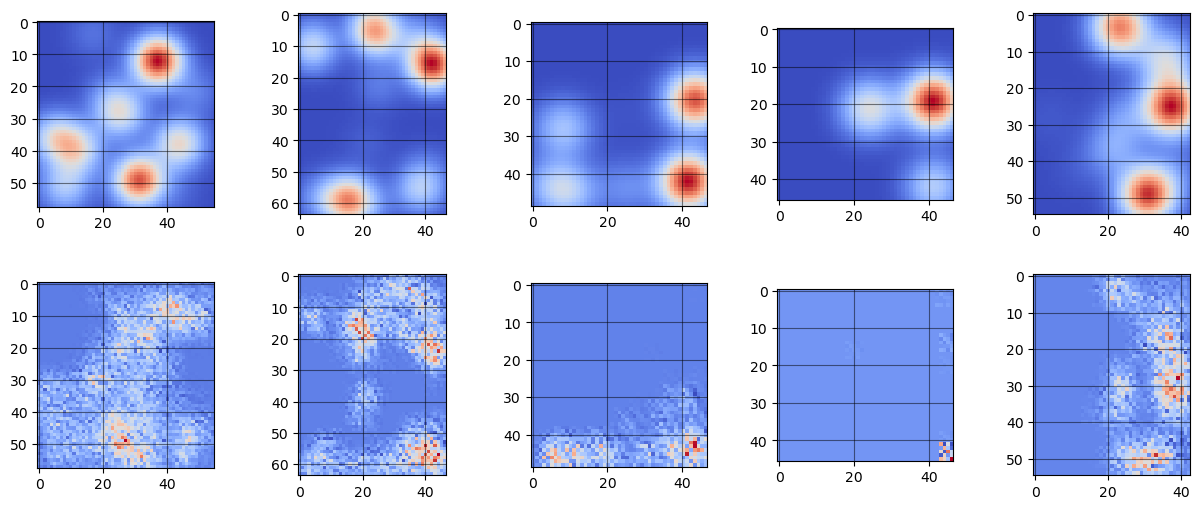

10
	0.03285
	0.03453
	0.03635
	0.03449
	0.04519
	0.03215
	0.03169
	0.03257
	0.03108
	0.03258
	0.03926
	0.03554
	0.05452
	0.03014
	0.03229
	0.03169
	0.03085
	0.03367
	0.03284
	0.03712
	0.03575
	0.05394
	0.03170
	0.03183
	0.02937
	0.03533
	0.05101
	0.03147
	0.03890
	0.05967
	0.04163
	0.03104
	0.03198
	0.03157
	0.03109
	0.03280
	0.03858
	0.03408
	0.04313
	0.02995
	0.03468
	0.03509
	0.04545
	0.03031
	0.03016
	0.03241
	0.02833
	0.03384
	0.03300
	0.05009
0.035991292


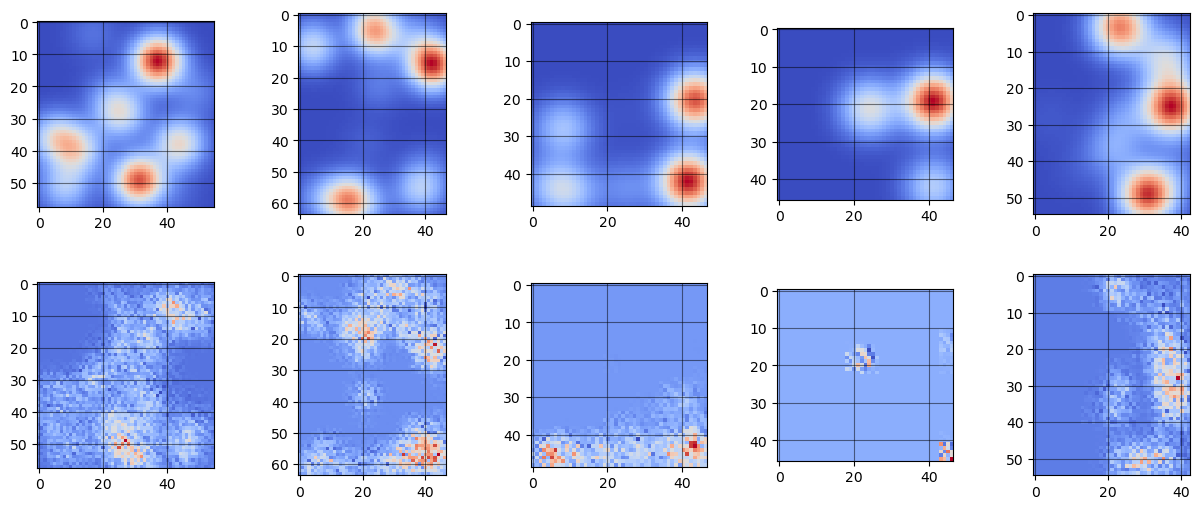

11
	0.03116
	0.03736
	0.05807
	0.04810
	0.03477
	0.03379
	0.03399
	0.03193
	0.03008
	0.03070
	0.03023
	0.03085
	0.02817
	0.03041
	0.03041
	0.03098
	0.03349
	0.04189
	0.03785
	0.05056
	0.02960
	0.03084
	0.03049
	0.03525
	0.04784
	0.02996
	0.03069
	0.03046
	0.03444
	0.03151
	0.03450
	0.03340
	0.04447
	0.02953
	0.03602
	0.03455
	0.04373
	0.02938
	0.02831
	0.02886
	0.03325
	0.03576
	0.05968
	0.04266
	0.03111
	0.03031
	0.02896
	0.03186
	0.03194
	0.03614
0.03500601


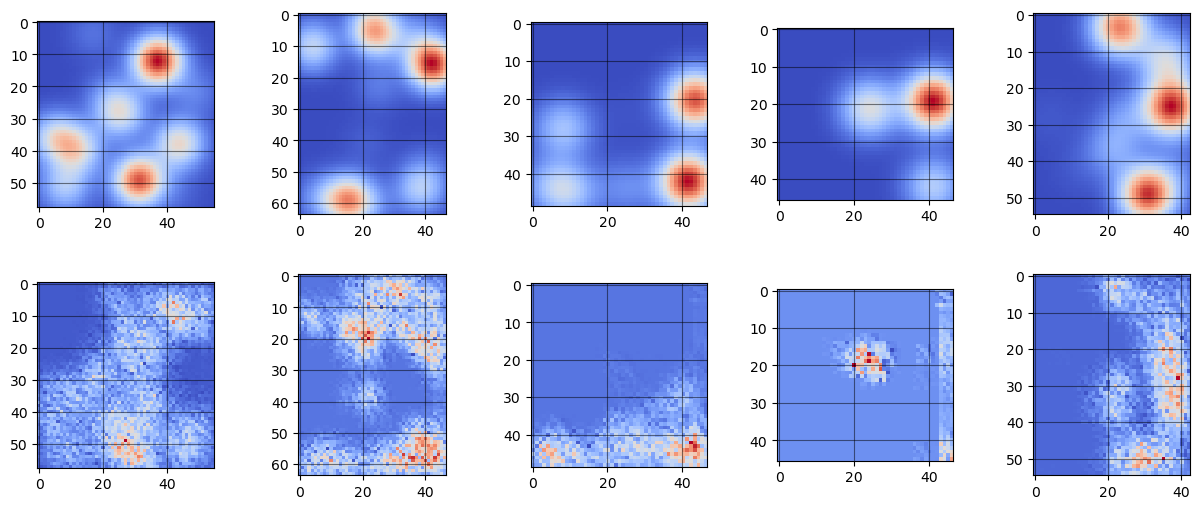

12
	0.03029
	0.02980
	0.03365
	0.03508
	0.03163
	0.03628
	0.03319
	0.04316
	0.03113
	0.03636
	0.03252
	0.03596
	0.03501
	0.04074
	0.02993
	0.03372
	0.03370
	0.04128
	0.03165
	0.03019
	0.03272
	0.04294
	0.02908
	0.03180
	0.03371
	0.05041
	0.03201
	0.03138
	0.03079
	0.02931
	0.03428
	0.03257
	0.03533
	0.03201
	0.03618
	0.03150
	0.04083
	0.03133
	0.02795
	0.02808
	0.02868
	0.02922
	0.02842
	0.02966
	0.03620
	0.03275
	0.03842
	0.03138
	0.04487
	0.02841
0.03375016


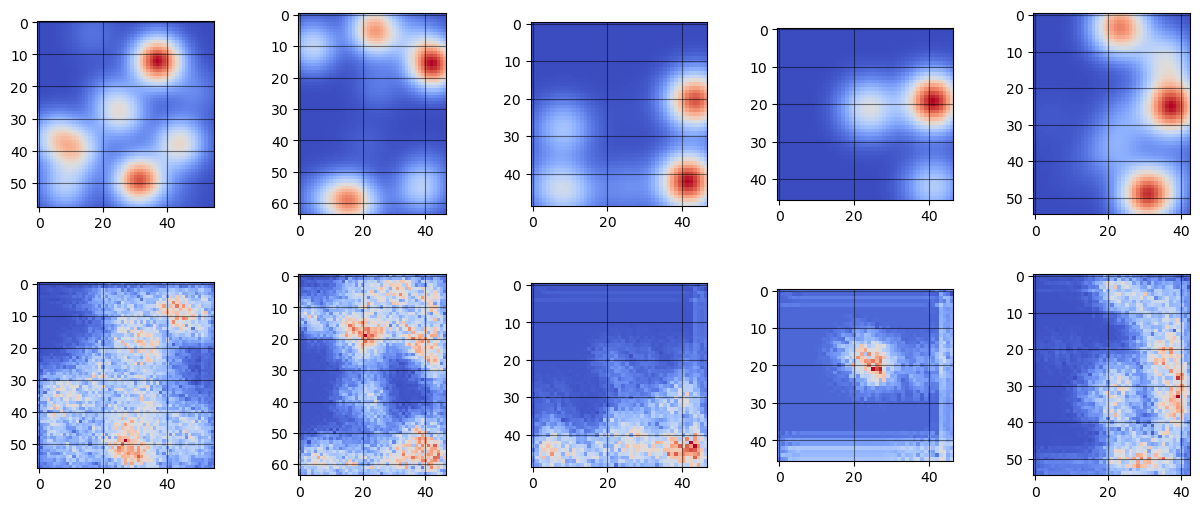

13
	0.03239
	0.03363
	0.03846
	0.03139
	0.03152
	0.03108
	0.04517
	0.02964
	0.02729
	0.02788
	0.02759
	0.02920
	0.02527
	0.02661
	0.02979
	0.03519
	0.06022
	0.03706
	0.03378
	0.03582
	0.03056
	0.03555
	0.03053
	0.03430
	0.03710
	0.05063
	0.03010
	0.02993
	0.03044
	0.03023
	0.02945
	0.02966
	0.02751
	0.02828
	0.02954
	0.03736
	0.03204
	0.03215
	0.03282
	0.04629
	0.02833
	0.02827
	0.02835
	0.03624
	0.02823
	0.03606
	0.03212
	0.03996
	0.03029
	0.02958
0.03301725


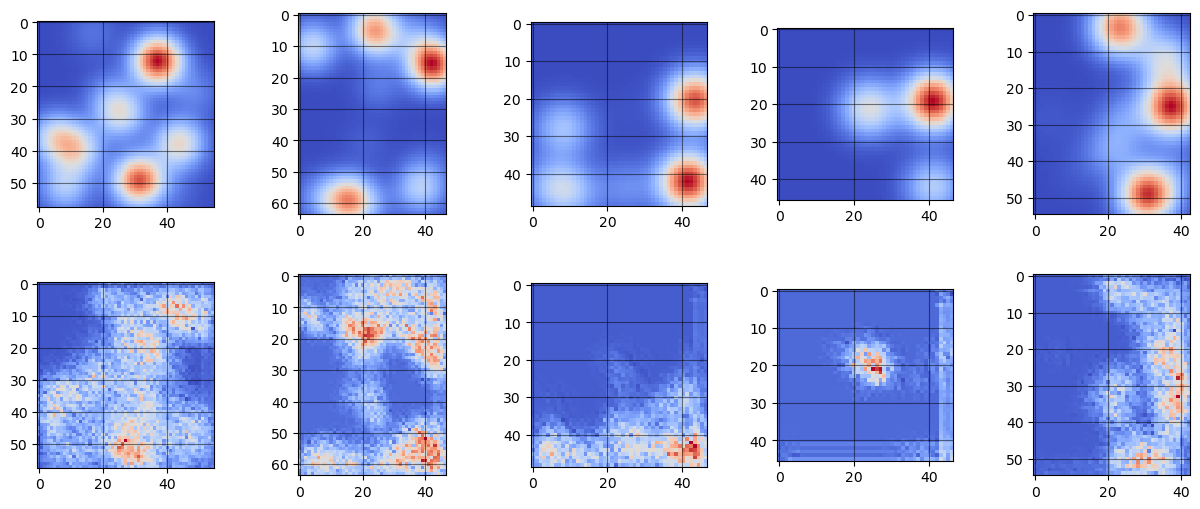

14
	0.03051
	0.03216
	0.03016
	0.04310
	0.02821
	0.03156
	0.03017
	0.03309
	0.03239
	0.03654
	0.02883
	0.02864
	0.02986
	0.03495
	0.03059
	0.03963
	0.02945
	0.03611
	0.03111
	0.04268
	0.03077
	0.02870
	0.02977
	0.03431
	0.02928
	0.03309
	0.02970
	0.03424
	0.03496
	0.04415
	0.03009
	0.03041
	0.02838
	0.03061
	0.03105
	0.03331
	0.03196
	0.03219
	0.03622
	0.03769
	0.02948
	0.02851
	0.02830
	0.03009
	0.02891
	0.03671
	0.03084
	0.03053
	0.03583
	0.04670
0.03273053


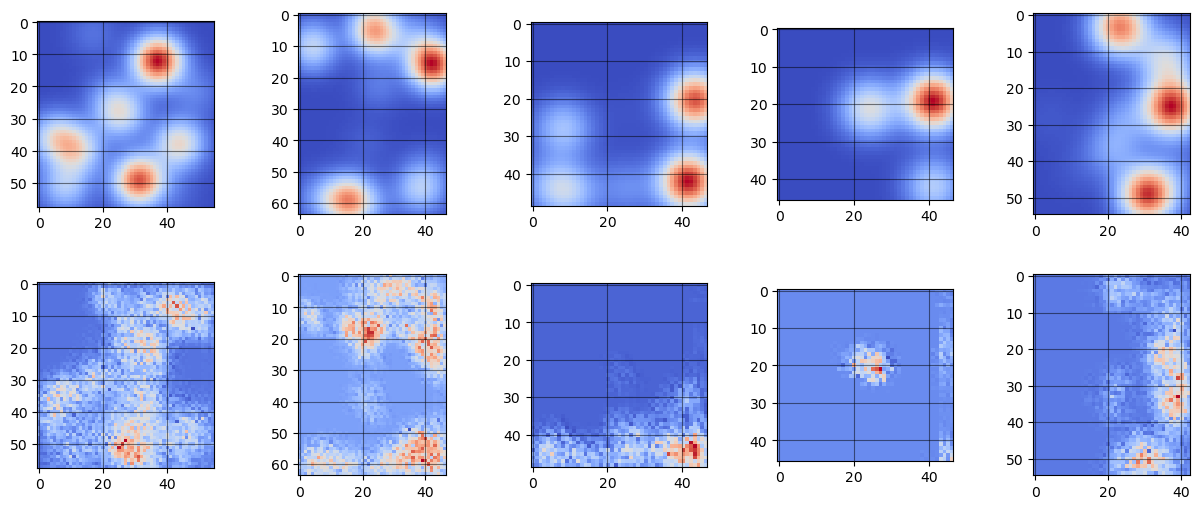

15
	0.02851
	0.02814
	0.02747
	0.02703
	0.02810
	0.03267
	0.03264
	0.04173
	0.02872
	0.03352
	0.03153
	0.04417
	0.02778
	0.02720
	0.02791
	0.02770
	0.02806
	0.03772
	0.02634
	0.02977
	0.03119
	0.04244
	0.02785
	0.03135
	0.03231
	0.03494
	0.03507
	0.05009
	0.03068
	0.02919
	0.02798
	0.02975
	0.03654
	0.02708
	0.02920
	0.02727
	0.03023
	0.02972
	0.03685
	0.03032
	0.03262
	0.02831
	0.03287
	0.03083
	0.03381
	0.03328
	0.04344
	0.02682
	0.02619
	0.03414
0.031781264


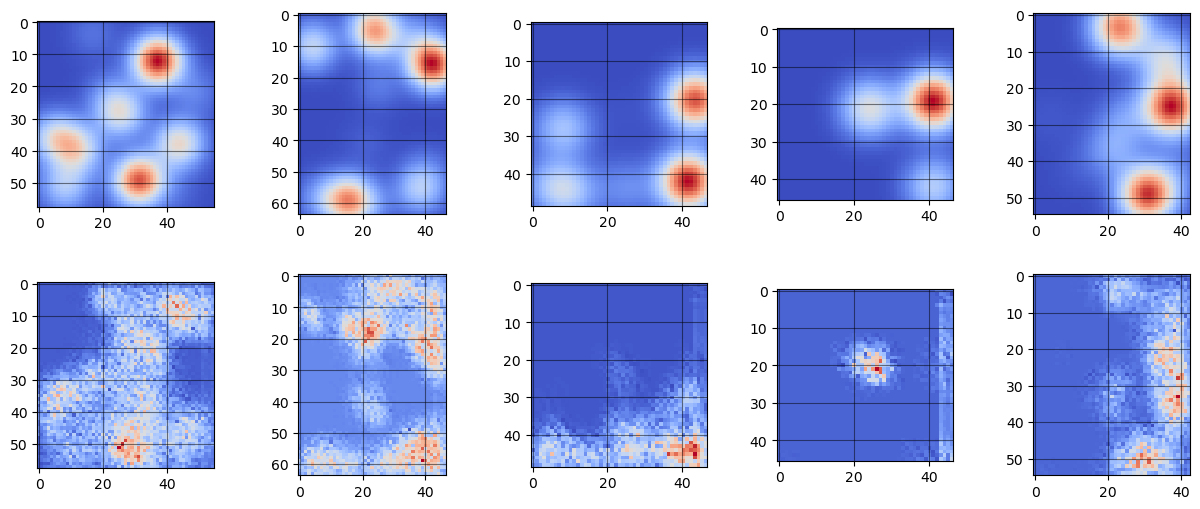

16
	0.02625
	0.02627
	0.02635
	0.02592
	0.02748
	0.03280
	0.04524
	0.02707
	0.02965
	0.02886
	0.03030
	0.02957
	0.03606
	0.03055
	0.03996
	0.02832
	0.03153
	0.03208
	0.04116
	0.02883
	0.02986
	0.02796
	0.03201
	0.02844
	0.03177
	0.02927
	0.03329
	0.02993
	0.03056
	0.03333
	0.05580
	0.03271
	0.02829
	0.03001
	0.02680
	0.02750
	0.02854
	0.03142
	0.02935
	0.03053
	0.02808
	0.02808
	0.03024
	0.04220
	0.02795
	0.02825
	0.02774
	0.02859
	0.03149
	0.04783
0.03144095


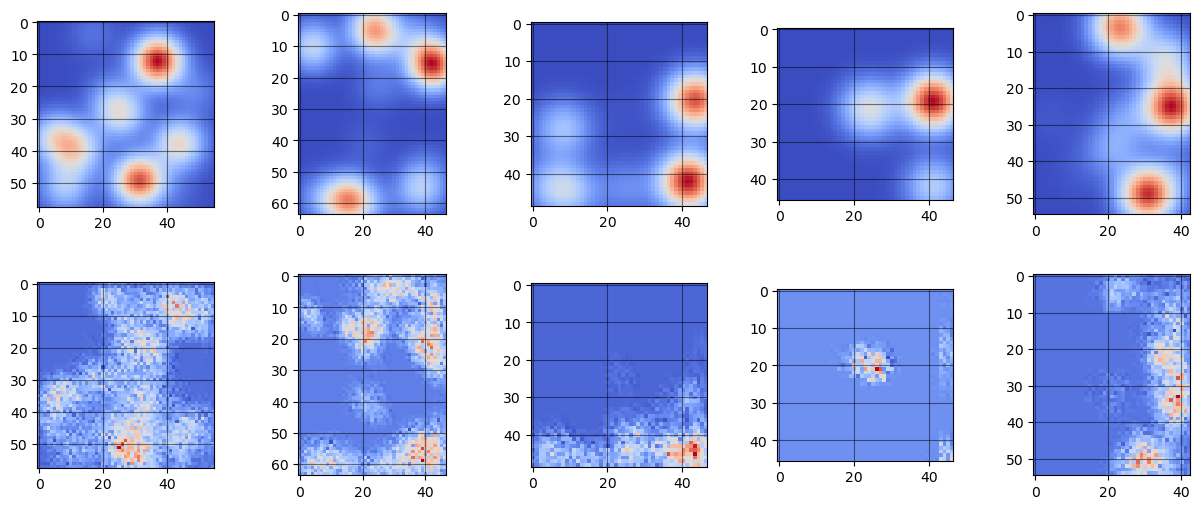

17
	0.02846
	0.02754
	0.02966
	0.02814
	0.03263
	0.02998
	0.03155
	0.02768
	0.03288
	0.03116
	0.03308
	0.02933
	0.02781
	0.02671
	0.02748
	0.02803
	0.03689
	0.02768
	0.02656
	0.03044
	0.03859
	0.02880
	0.03166
	0.02877
	0.03691
	0.02951
	0.02843
	0.02845
	0.02915
	0.02645
	0.02978
	0.03018
	0.03177
	0.03141
	0.04018
	0.02822
	0.03102
	0.03215
	0.03544
	0.02816
	0.03589
	0.02757
	0.03006
	0.03068
	0.03386
	0.02628
	0.03032
	0.02728
	0.03234
	0.03109
0.030481886


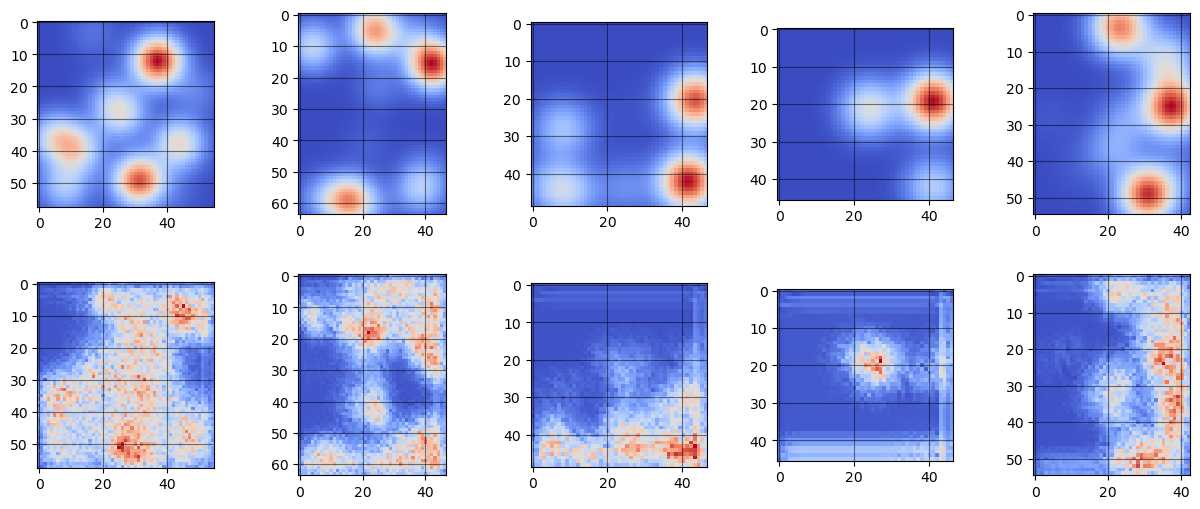

18
	0.03718
	0.02677
	0.02612
	0.02618
	0.02692
	0.02955
	0.03280
	0.03114
	0.04217
	0.02686
	0.02771
	0.02659
	0.02627
	0.02746
	0.02768
	0.03120
	0.02931
	0.03129
	0.03381
	0.04663
	0.02700
	0.02657
	0.02555
	0.02592
	0.02620
	0.02464
	0.02545
	0.02552
	0.02690
	0.02796
	0.03321
	0.03929
	0.02689
	0.02739
	0.02787
	0.03573
	0.03009
	0.03841
	0.02838
	0.02826
	0.02648
	0.02718
	0.02990
	0.03675
	0.03104
	0.03156
	0.02847
	0.02811
	0.02544
	0.03236
0.02976323


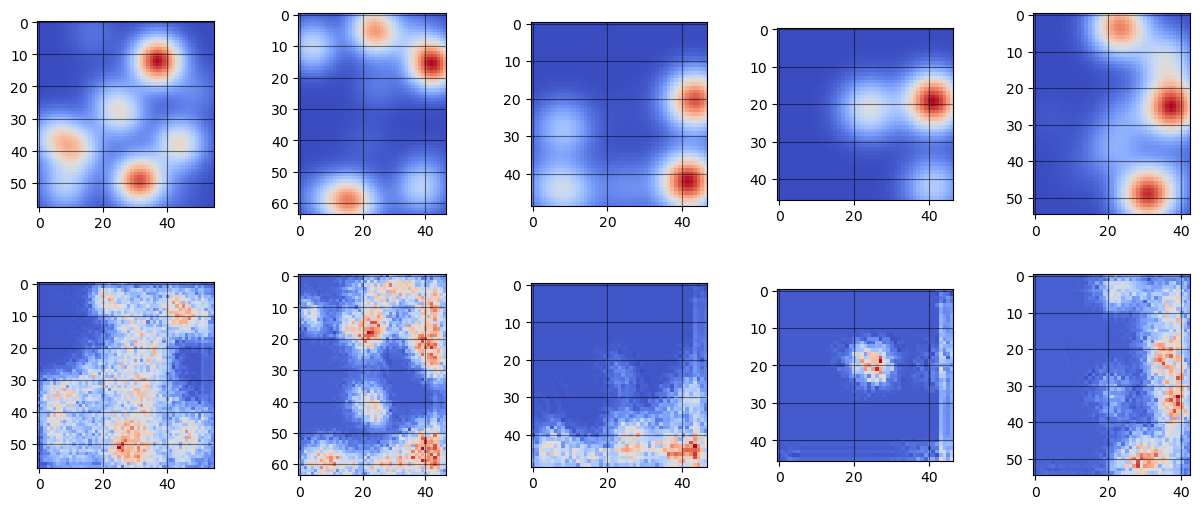

19
	0.03209
	0.04431
	0.02644
	0.02537
	0.02557
	0.02443
	0.02533
	0.02440
	0.02567
	0.02648
	0.02675
	0.02794
	0.04532
	0.02486
	0.02583
	0.02604
	0.02862
	0.03007
	0.03740
	0.02968
	0.03552
	0.03116
	0.04057
	0.02410
	0.02569
	0.02434
	0.02670
	0.02905
	0.03232
	0.02930
	0.03451
	0.02992
	0.03235
	0.02584
	0.02738
	0.03154
	0.03847
	0.02993
	0.03152
	0.02947
	0.03378
	0.02608
	0.02631
	0.02831
	0.02725
	0.03014
	0.03321
	0.03264
	0.03377
	0.02878
0.029850872


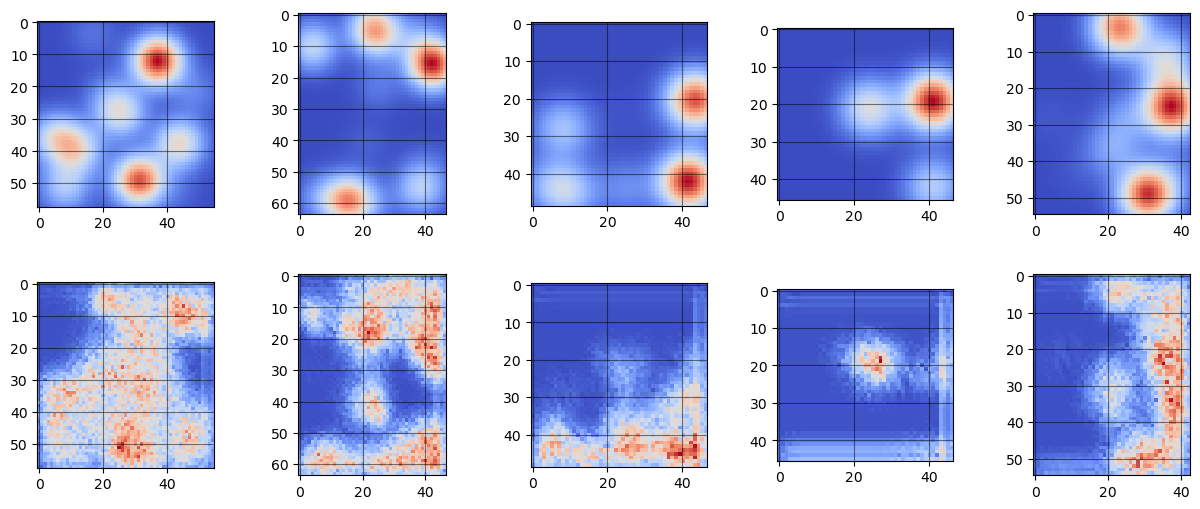

20
	0.02977
	0.02791
	0.03482
	0.02552
	0.02825
	0.02941
	0.03278
	0.02908
	0.02898
	0.02756
	0.03077
	0.02895
	0.02867
	0.02760
	0.04008
	0.02640
	0.03050
	0.02653
	0.03263
	0.03086
	0.03524
	0.02625
	0.02584
	0.02689
	0.02529
	0.02398
	0.02654
	0.02803
	0.04367
	0.02472
	0.03074
	0.03181
	0.03510
	0.02679
	0.02773
	0.02709
	0.02889
	0.02943
	0.03045
	0.02592
	0.02910
	0.02769
	0.02919
	0.02811
	0.03748
	0.02548
	0.03474
	0.02547
	0.02783
	0.02658
0.029382847


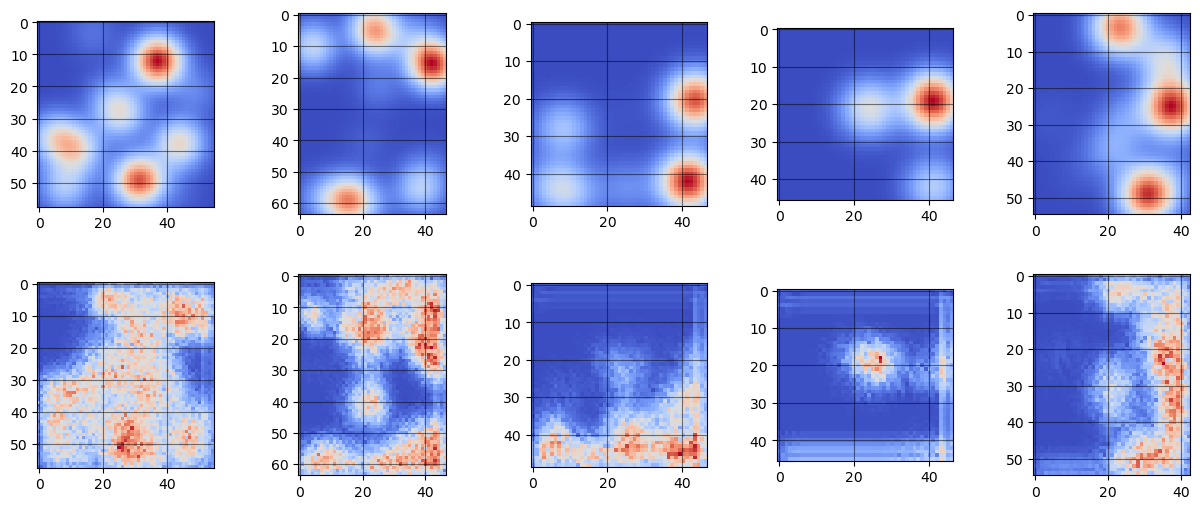

21
	0.02874
	0.02912
	0.03505
	0.02512
	0.02836
	0.02667
	0.03223
	0.02906
	0.02843
	0.02797
	0.04056
	0.02460
	0.02460
	0.02613
	0.02483
	0.02617
	0.02437
	0.02540
	0.02474
	0.02502
	0.02428
	0.02446
	0.02381
	0.02932
	0.03177
	0.04672
	0.02522
	0.02668
	0.02537
	0.02558
	0.02913
	0.03100
	0.02757
	0.03105
	0.02617
	0.03241
	0.02739
	0.03526
	0.02686
	0.03198
	0.02673
	0.03069
	0.02966
	0.03686
	0.02509
	0.02424
	0.02757
	0.03373
	0.02791
	0.02860
0.028605646


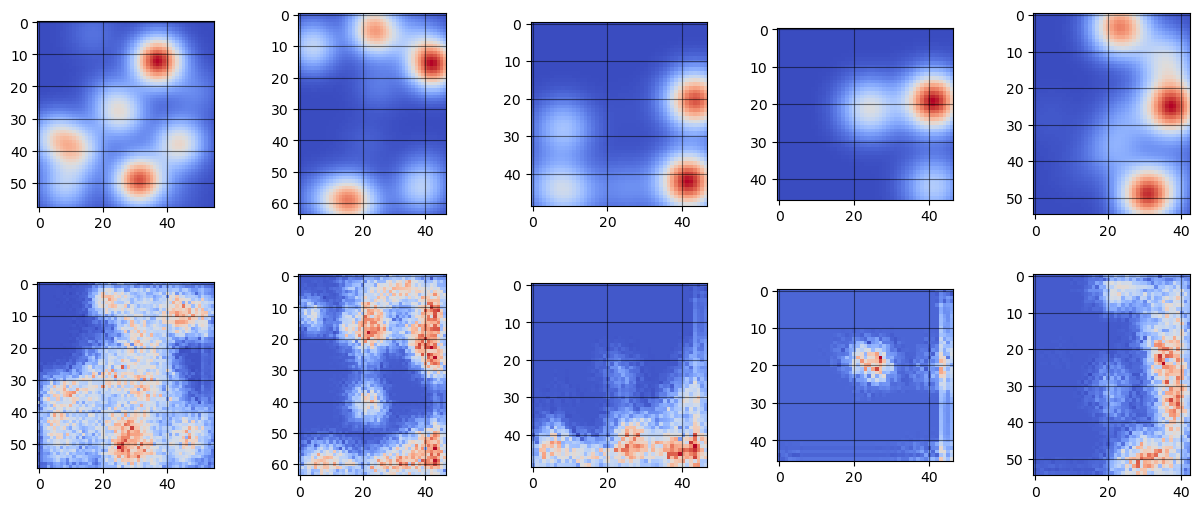

22
	0.02864
	0.03316
	0.02573
	0.02909
	0.02662
	0.02665
	0.02556
	0.03111
	0.02704
	0.03065
	0.02745
	0.03372
	0.02646
	0.02918
	0.02814
	0.03097
	0.02569
	0.02700
	0.02731
	0.02865
	0.02705
	0.03240
	0.03130
	0.03160
	0.02587
	0.02564
	0.02680
	0.03379
	0.02829
	0.02709
	0.02324
	0.02541
	0.02588
	0.02613
	0.02473
	0.03781
	0.02625
	0.02968
	0.02892
	0.03858
	0.02664
	0.02709
	0.02632
	0.02729
	0.02980
	0.03293
	0.02710
	0.03014
	0.02690
	0.02937
0.02857737


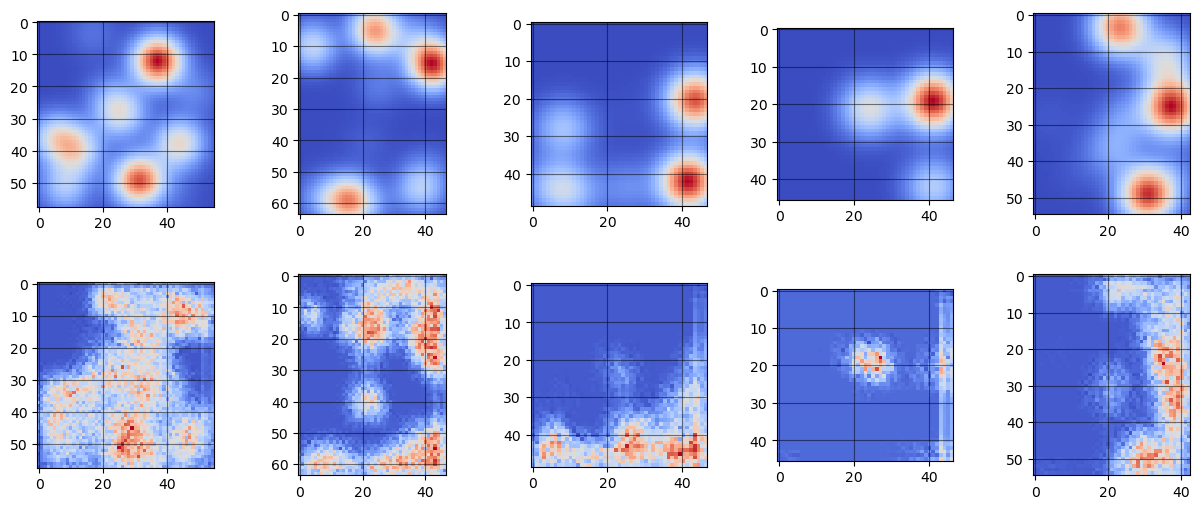

23
	0.02603


KeyboardInterrupt: 

In [28]:
np.random.seed(123)
errors = []
losses = []


for e in range(500):
    print(e)
    batches_n  = 50
    indici     = np.random.choice(len(anchorpts_vox_train),
                                  len(anchorpts_vox_train),
                                  False)
    batches    = np.array_split( indici , batches_n)
    for batch in batches:
        samples = extract_batch(magic_shape,atomcoord_vox_train,batch) #PAD_atomcoord_vox_train[batch]
        ligands = ligand_train[batch]
        labels  = extract_batch(magic_shape,anchorpts_vox_train,batch) #PAD_anchorpts_vox_train[batch]
            
        g      = batch_grad(     ktf, btf, wo, bo,
                                 samples,ligands, alpha, labels)
        lr  = 1e-1
        
        ktf = [ k - lr * gr for k,gr in zip(ktf, g[0])]
        btf = [ b - lr * gr for b,gr in zip(btf, g[1])]
        wo  = [ w - lr * gr for w,gr in zip(wo , g[2])]
        bo  = [ b - lr * gr for b,gr in zip(bo , g[3])]
        
        curr_loss = batch_loss(  ktf, btf, wo, bo,
                                 samples,ligands,alpha,labels)
        
        errors.append(curr_loss)
        losses.append(np.mean(errors[-batches_n:]))
        print("\t%.5f" % curr_loss)
    print(losses[-1])
    
    ##################### check fetta
    
    fetta = 15
    
    axs = plt.figure(figsize=(15,6)).subplots(2,5)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.4) 


    for img in range(5):

        sample = 10 * img

        axs[0,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')
        axs[1,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')


        axs[0,img].imshow( anchorpts_vox_train[sample][fetta,:,:] , cmap = 'coolwarm')
        axs[1,img].imshow( logistic_model(
                                  ktf, btf, wo, bo,
                                  atomcoord_vox_train[sample],
                                  ligand_train[sample], 
                                  1.0)[fetta,:,:] , alpha = 1.0, cmap = 'coolwarm' )
    
    plt.show()
    
    
plt.figure()
plt.plot(losses)

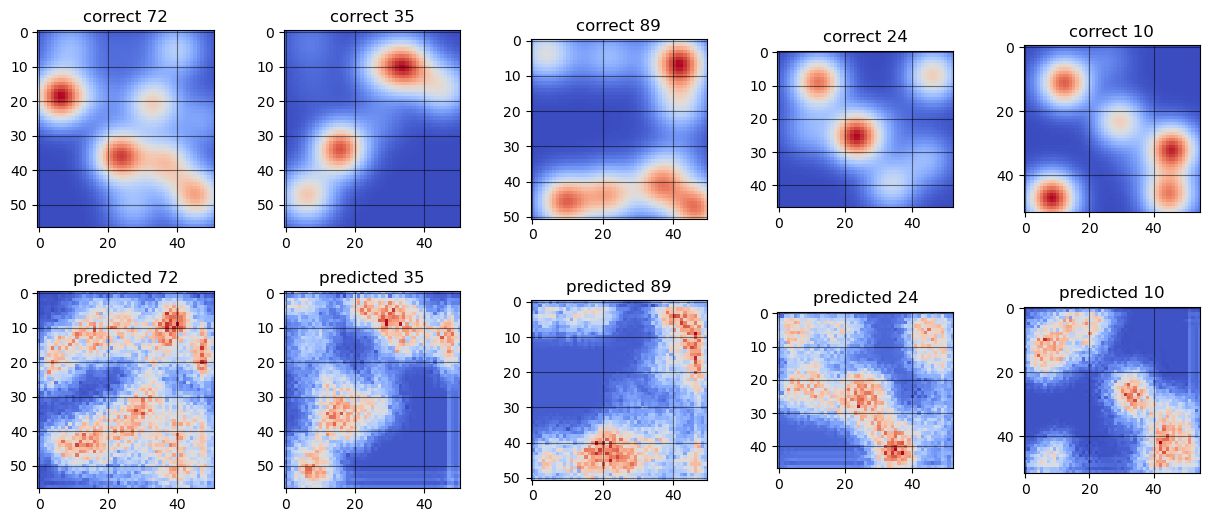

In [29]:
axs = plt.figure(figsize=(15,6)).subplots(2,5)
plt.subplots_adjust(hspace = 0.3, wspace = 0.4) 

#np.random.seed(789)

for img in range(5):

    sample = np.random.choice(len(ligand_test))
    
    axs[0,img].set_title("correct %d" % sample)
    axs[0,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')
    
    axs[1,img].set_title("predicted %d" % sample)    
    axs[1,img].grid(visible=True, which='major', color='black', alpha = 0.5, linestyle='-')

    axs[0,img].imshow( anchorpts_vox_test[sample][fetta,:,:] , cmap = 'coolwarm')
    axs[1,img].imshow( logistic_model(
                              ktf, btf, wo, bo,
                              atomcoord_vox_test[sample],
                              ligand_test[sample], 
                              1.0)[fetta,:,:] , alpha = 1.0, cmap = 'coolwarm' )
    
    
plt.show()

## Save Big Model

In [30]:
import os

big_models_folders = "big_models"
N_models = len(next(os.walk(big_models_folders))[1])
new_folder_id = N_models


# creo la cartella
path_curr_model = big_models_folders + "/" + str(new_folder_id)
path_curr_model_ktf = "%s/ktf" % (path_curr_model)
path_curr_model_btf = "%s/btf" % (path_curr_model)
path_curr_model_wo  = "%s/wo"  % (path_curr_model)
path_curr_model_bo  = "%s/bo"  % (path_curr_model)

os.mkdir(path_curr_model)
os.mkdir(path_curr_model_ktf)
os.mkdir(path_curr_model_btf)
os.mkdir(path_curr_model_wo)
os.mkdir(path_curr_model_bo)


# Salvo i kernel
for i,k in enumerate(ktf):
    np.save(path_curr_model_ktf + ("/kernel_%d" % i) , np.array(k))

# Salvo i bias convolutivi
for i,b in enumerate(btf):
    np.save(path_curr_model_btf + ("/bias_%d" % i) , b)
    
# Salvo i weights dell'oracolo
for i,w in enumerate(wo):
    np.save(path_curr_model_wo + ("/weight_oracle_%d" % i) , w)

# Salvo i bias dell'oracolo
for i,b in enumerate(bo):
    np.save(path_curr_model_bo + ("/bias_oracle_%d" % i) , b)    


## salvo file con alcune informazioni
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d %H-%M-%S")

# convert datetime obj to string
str_current_datetime = str(current_datetime)
# 
## create a file object along with extension
file_name = str_current_datetime+".log"
file = open(path_curr_model + "/" + file_name, 'w')
file.write(str_current_datetime + "\n")
file.write("TEST LOSS = %.10f\n" % batch_loss(  ktf, btf, wo, bo,
                                   extract_batch(magic_shape,atomcoord_vox_train,np.arange(len(ligand_test))),
                                   ligand_test,
                                   1.0,
                                   extract_batch(magic_shape,anchorpts_vox_train,np.arange(len(ligand_test)))))
file.close()


# salvo una copia dell autoencoder ligandi...

path_curr_model_encoder = "%s/ligand_encoder" % (path_curr_model)
path_curr_model_decoder = "%s/ligand_decoder" % (path_curr_model)

os.mkdir(path_curr_model_encoder)
os.mkdir(path_curr_model_decoder)

# Salvo l'encoder
for i,e in enumerate(params_E):
    np.save(path_curr_model_encoder + ("/encoder_param_%d" % i) , np.array(e))

# Salvo il decoder
for i,d in enumerate(params_D):
    np.save(path_curr_model_decoder + ("/decoder_param_%d" % i) , np.array(d))

# Test

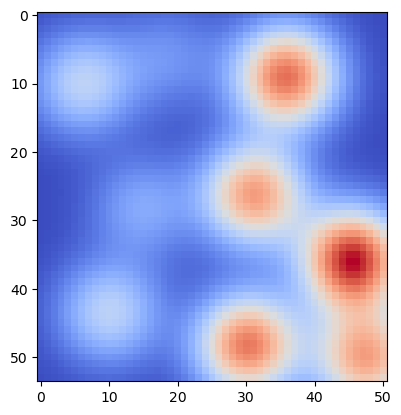

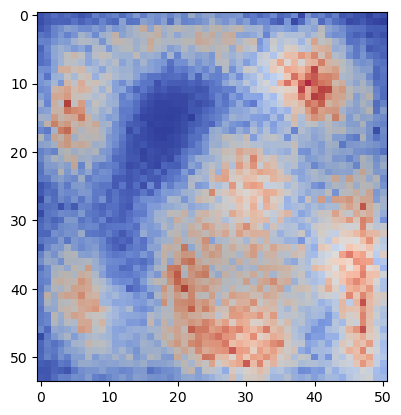

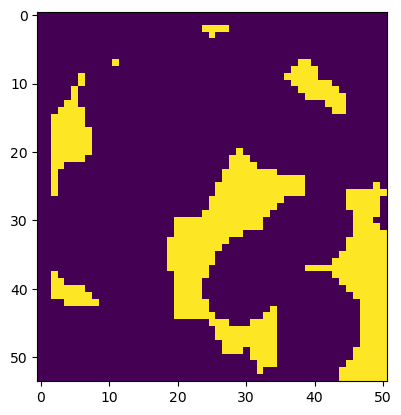

In [31]:
fetta = 20
sample = 1
plt.imshow( anchorpts_vox_test[sample][fetta,:,:] , cmap = 'coolwarm')
plt.figure()
plt.imshow( anchorpts_vox_test[sample][fetta,:,:] , cmap = 'gray')
plt.imshow(logistic_model(
                          ktf, btf, wo, bo,
                          atomcoord_vox_test[sample],
                          ligand_test[sample], 
                          1.0)[fetta,:,:] , alpha = 0.8, cmap = 'coolwarm' )
plt.figure()
plt.imshow( atomcoord_vox_test[sample][fetta,:,:])
plt.show()

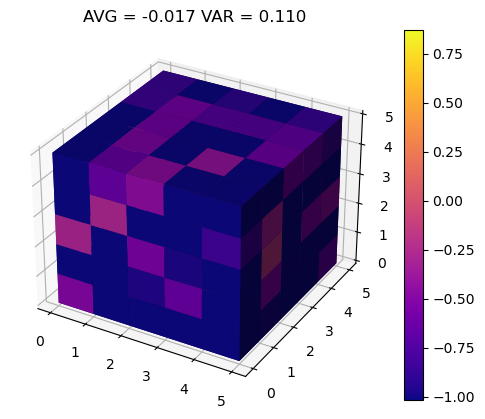

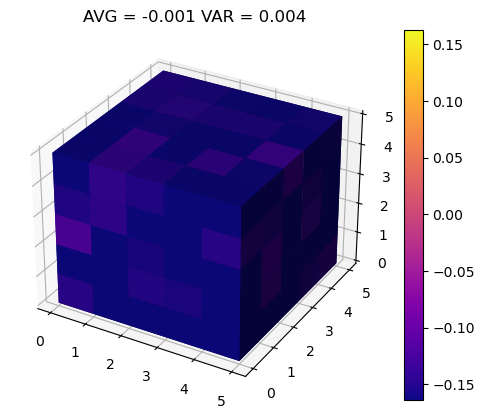

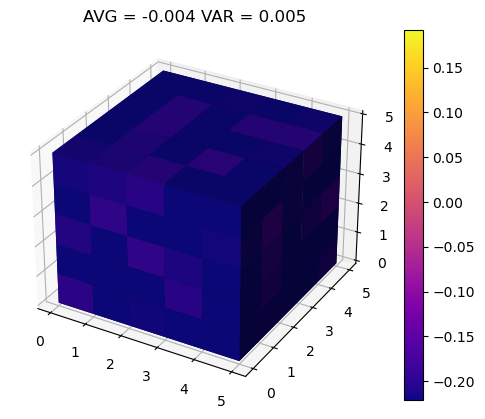

In [32]:
from matplotlib import colors,cm
for s in [10,20,30]:
    fig    = plt.figure()
    ax     = fig.add_subplot(projection = '3d')
    img    = chemical_contribution(wo,bo,ligand_train[s])
    ax.set_title("AVG = %.3f VAR = %.3f" % (img.mean(),img.var()))
    colori = plt.cm.plasma(img)
    v      = ax.voxels( img, facecolors = colori, alpha = 1. )

    norm = colors.Normalize(vmin=img.min(), vmax=img.max())
    m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    m.set_array([])
    plt.colorbar(m)
    plt.show()


In [82]:
sample = 17
V_A_hat = np.array  (
                    logistic_model
                                 (
                                      ktf, btf, wo, bo,
                                      atomcoord_vox_train[sample],
                                      ligand_train[sample], 
                                      1.0
                                 )
                    )
V_A     = np.array(anchorpts_vox_test[sample])
V_X     = np.array(atomcoord_vox_test[sample])

(array([44926., 29631., 19154., 17809., 18000., 16206., 16518., 17165.,
        15483.,   784.]),
 array([-0.03026948,  0.03291195,  0.09609338,  0.1592748 ,  0.22245623,
         0.28563765,  0.34881908,  0.4120005 ,  0.47518194,  0.5383634 ,
         0.6015448 ], dtype=float32),
 <BarContainer object of 10 artists>)

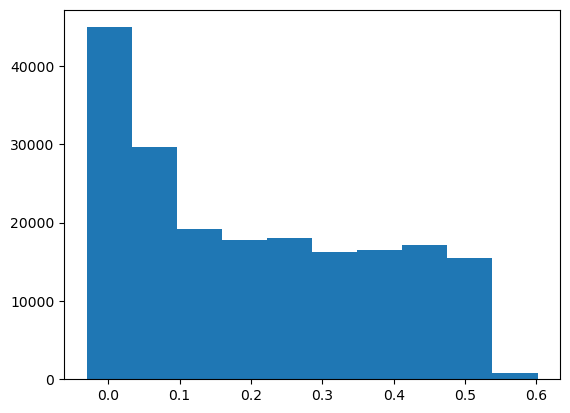

In [83]:
plt.hist( V_A_hat.flatten() )

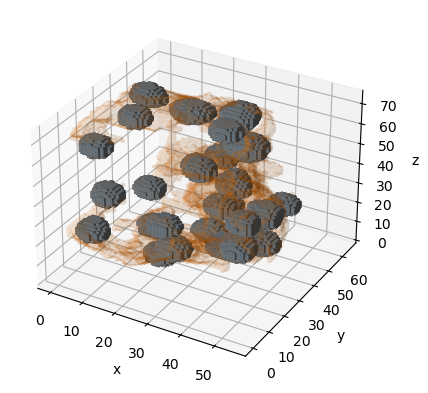

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(V_A > 0.7, edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

ax = make_ax(True)
ax.voxels(V_A_hat > (0.8 * (V_A_hat.max() - V_A_hat.min()) + V_A_hat.min()), edgecolors='gray', shade=True)
ax.voxels(V_X, edgecolors='gray', lw = 0., alpha = 0.1, shade=True)
plt.show()

In [ ]:
V_A_hat.shape

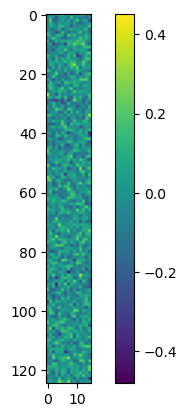

In [64]:
plt.imshow(W_6)
plt.colorbar()

In [127]:
b_f_4

DeviceArray(0.03047841, dtype=float32, weak_type=True)

$f({\bf x} + H_f^{-1} \nabla f({\bf x}) ) \approx f({\bf x}) + \nabla f({\bf x})^T H_f^{-1} \nabla f({\bf x})  + \nabla f({\bf x})^T H_f^{-1}  H_f({\bf x}) H_f^{-1} \nabla f({\bf x}) $

In [57]:
v = np.arange(5)**2
v[[0,2,3]]

array([0, 4, 9])